In [1]:
using SQLite
using DataFrames
using Pipe
using LinearAlgebra

In [2]:
using MLBase
using DecisionTree
using Distances
using NearestNeighbors
using Random
using LinearAlgebra
using DataStructures
using LIBSVM

In [3]:
db = SQLite.DB("C:\\Users\\posit\\Dropbox\\SQL Databases\\lahmansbaseballdb.sqlite")

SQLite.DB("C:\Users\posit\Dropbox\SQL Databases\lahmansbaseballdb.sqlite")

In [4]:
SQLite.tables(db) |> DataFrame

,name
,String
1,allstarfull
2,appearances
3,awardsmanagers
4,awardsplayers
5,awardssharemanagers
6,awardsshareplayers
7,batting
8,battingpost
9,collegeplaying


In [5]:
df = DBInterface.execute(db, "SELECT * FROM batting") |> DataFrame;
people = DBInterface.execute(db, "SELECT * FROM people") |> DataFrame;
all_star = DBInterface.execute(db, "SELECT * FROM allstarfull") |> DataFrame;

In [7]:
grouped = groupby(df, :playerID);

In [8]:
grouped[2345]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB
,Int64,String,Int64,Int64,String,Int64,String,Int64,Missing,Int64
1,8494,vanzaik01,1901,1,NY1,394,NL,3,missing,6
2,9756,vanzaik01,1904,1,CHN,436,NL,3,missing,11
3,10158,vanzaik01,1905,1,SLA,461,AL,94,missing,322


In [9]:
length(grouped)

19689

In [10]:
grouped[2345][1,:]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB
,Int64,String,Int64,Int64,String,Int64,String,Int64,Missing,Int64
8494,8494,vanzaik01,1901,1,NY1,394,NL,3,missing,6


In [11]:
first_season = DataFrame(grouped[1][1,:])

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB
,Int64,String,Int64,Int64,String,Int64,String,Int64,Missing,Int64
1,1,abercda01,1871,1,TRO,8,NA,1,missing,4


In [12]:
first_season = first_season[first_season[:ID] .!= 1, :]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB
,Int64,String,Int64,Int64,String,Int64,String,Int64,Missing,Int64


In [13]:
for i in 1:length(grouped)
    temp = DataFrame(grouped[i][1,:])
    append!(first_season,temp)
end

In [14]:
nrow(first_season)

19689

In [15]:
first_100 = first_season[first_season[:AB] .>= 100,:];
nrow(first_100)

2977

In [16]:
first_1970 = first_100[first_100[:yearID] .>= 1970,:];
first_1970 = first_1970[first_1970[:yearID] .< 2019,:];
nrow(first_1970)

1087

In [17]:
players = first_1970[:playerID];
typeof(players)

Array{String,1}

In [18]:
players_all_star = all_star[findall(in(players), all_star[:playerID]), :];
nrow(players_all_star)

876

In [19]:
first_1970[190,:playerID] in players_all_star[:playerID]

true

In [20]:
as = []
for i in 1:nrow(first_1970)
    temp = ifelse.(first_1970[i, :playerID] in players_all_star[:playerID], 1, 0)
    append!(as, temp)
end

In [21]:
as[190]

1

In [22]:
first_1970[:AS] = as;

In [23]:
names(first_1970)

26-element Array{String,1}:
 "ID"
 "playerID"
 "yearID"
 "stint"
 "teamID"
 "team_ID"
 "lgID"
 "G"
 "G_batting"
 "AB"
 "R"
 "H"
 "2B"
 "3B"
 "HR"
 "RBI"
 "SB"
 "CS"
 "BB"
 "SO"
 "IBB"
 "HBP"
 "SH"
 "SF"
 "GIDP"
 "AS"

In [24]:
describe(first_1970)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,playerID,,abercre01,,zuninmi01,1087,,String
3,yearID,1998.22,1970,2001.0,2018,,,Int64
4,stint,1.0,1,1.0,1,,,Int64
5,teamID,,ANA,,WS2,36,,String
6,team_ID,2307.06,1546,2363.0,2895,,,Int64
7,lgID,,AL,,NL,2,,String
8,G,76.0948,27,68.0,163,,,Int64
9,G_batting,,,,,,1087,Missing


In [25]:
select!(first_1970, Not(:G_batting));
describe(first_1970)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,playerID,,abercre01,,zuninmi01,1087,,String
3,yearID,1998.22,1970,2001.0,2018,,,Int64
4,stint,1.0,1,1.0,1,,,Int64
5,teamID,,ANA,,WS2,36,,String
6,team_ID,2307.06,1546,2363.0,2895,,,Int64
7,lgID,,AL,,NL,2,,String
8,G,76.0948,27,68.0,163,,,Int64
9,AB,239.186,100,198.0,692,,,Int64


In [26]:
first_1970["AVG"] = first_1970[:"H"] ./ first_1970[:"AB"];
first_1970["OBP"] = (first_1970[:"H"] + first_1970[:"BB"] + first_1970[:"HBP"])./(first_1970[:"AB"] + first_1970[:"BB"] + first_1970[:"HBP"] + first_1970[:"SF"]);
first_1970["Singles"] = first_1970[:"H"] - first_1970[:"2B"] - first_1970[:"3B"] - first_1970[:"HR"];
first_1970["SLG"] = (first_1970[:"Singles"] + (first_1970[:"2B"]*2) + (first_1970[:"3B"]*3) + (first_1970[:"HR"]*4)) ./ first_1970[:"AB"];
first_1970["OPS"] = first_1970["OBP"] .+ first_1970["SLG"];

In [27]:
describe(first_1970)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,playerID,,abercre01,,zuninmi01,1087,,String
3,yearID,1998.22,1970,2001.0,2018,,,Int64
4,stint,1.0,1,1.0,1,,,Int64
5,teamID,,ANA,,WS2,36,,String
6,team_ID,2307.06,1546,2363.0,2895,,,Int64
7,lgID,,AL,,NL,2,,String
8,G,76.0948,27,68.0,163,,,Int64
9,AB,239.186,100,198.0,692,,,Int64


In [28]:
first_1970[first_1970[:Singles].==192,:]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,AB,R,H
,Int64,String,Int64,Int64,String,Int64,String,Int64,Int64,Int64,Int64
1,81818,suzukic01,2001,1,SEA,2380,AL,157,692,127,242


In [29]:
first_1970[first_1970[:SLG].==0.71,:]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,AB,R,H
,Int64,String,Int64,Int64,String,Int64,String,Int64,Int64,Int64,Int64
1,86602,jacobmi02,2005,1,NYN,2494,NL,30,100,19,31


In [30]:
first_1970[first_1970[:AVG].>=0.35,:]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,AB,R,H
,Int64,String,Int64,Int64,String,Int64,String,Int64,Int64,Int64,Int64
1,49879,stennre01,1971,1,PIT,1585,NL,50,153,24,54
2,68590,barbebr01,1991,1,MON,2088,NL,57,136,16,48
3,89070,ellsbja01,2007,1,BOS,2539,AL,33,116,20,41


In [31]:
using Plots

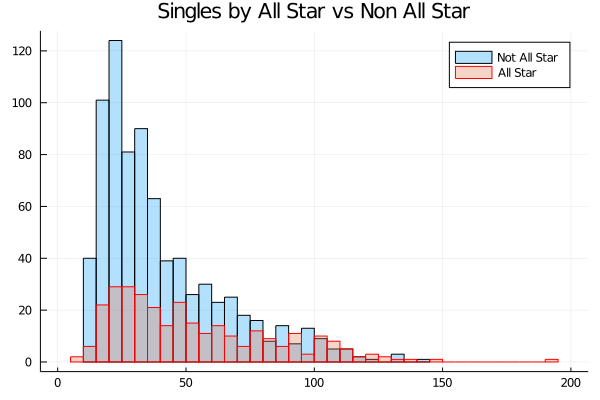

In [32]:
histogram(first_1970[:Singles][first_1970[:AS] .==0],nbins=50,fillalpha=0.3,label="Not All Star",title = "Singles by All Star vs Non All Star")
histogram!(first_1970[:Singles][first_1970[:AS] .==1], nbins=50,linecolor=:red,fillalpha=0.3,label="All Star")

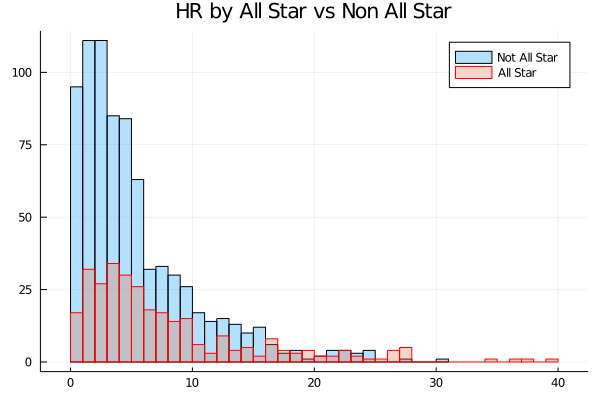

In [33]:
histogram(first_1970[:HR][first_1970[:AS] .==0],nbins=50,fillalpha=0.3,label="Not All Star",title = "HR by All Star vs Non All Star")
histogram!(first_1970[:HR][first_1970[:AS] .==1], nbins=50,linecolor=:red,fillalpha=0.3,label="All Star")

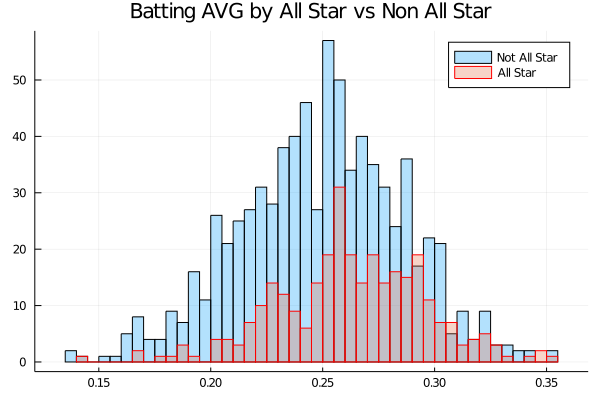

In [34]:
histogram(first_1970[:AVG][first_1970[:AS] .==0],nbins=50,fillalpha=0.3,label="Not All Star",title = "Batting AVG by All Star vs Non All Star")
histogram!(first_1970[:AVG][first_1970[:AS] .==1], nbins=50,linecolor=:red,fillalpha=0.3,label="All Star")

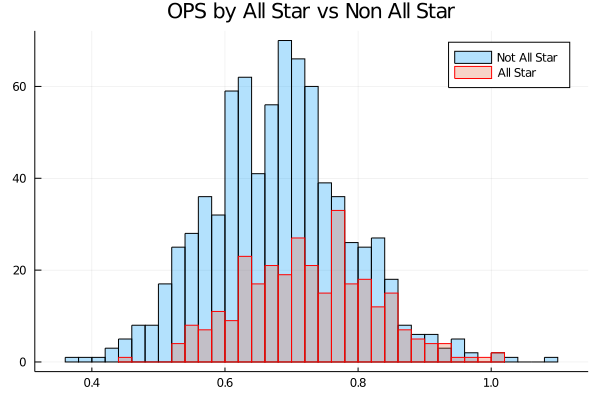

In [35]:
histogram(first_1970[:OPS][first_1970[:AS] .==0],nbins=50,fillalpha=0.3,label="Not All Star",title = "OPS by All Star vs Non All Star")
histogram!(first_1970[:OPS][first_1970[:AS] .==1], nbins=50,linecolor=:red,fillalpha=0.3,label="All Star")

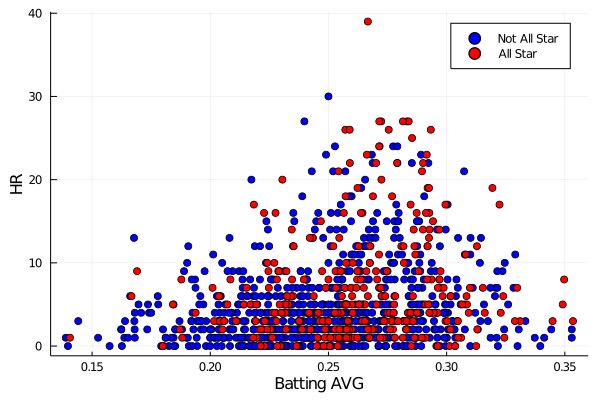

In [36]:
scatter(first_1970[:AVG][first_1970[:AS] .==0], first_1970[:HR][first_1970[:AS] .==0],color="blue",label="Not All Star")
scatter!(first_1970[:AVG][first_1970[:AS] .==1], first_1970[:HR][first_1970[:AS] .==1], color="red",label="All Star")
Plots.xlabel!("Batting AVG")
Plots.ylabel!("HR")

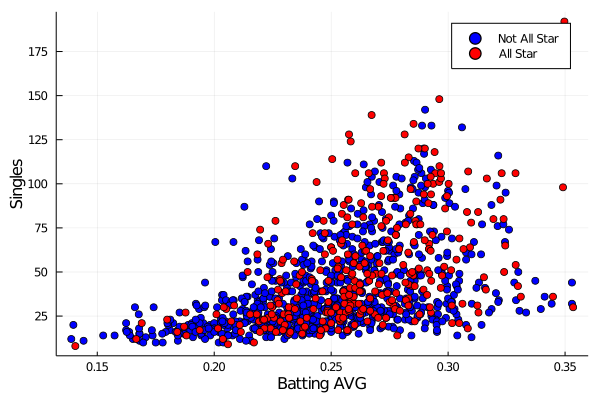

In [37]:
scatter(first_1970[:AVG][first_1970[:AS] .==0], first_1970[:Singles][first_1970[:AS] .==0],color="blue",label="Not All Star")
scatter!(first_1970[:AVG][first_1970[:AS] .==1], first_1970[:Singles][first_1970[:AS] .==1], color="red",label="All Star")
Plots.xlabel!("Batting AVG")
Plots.ylabel!("Singles")

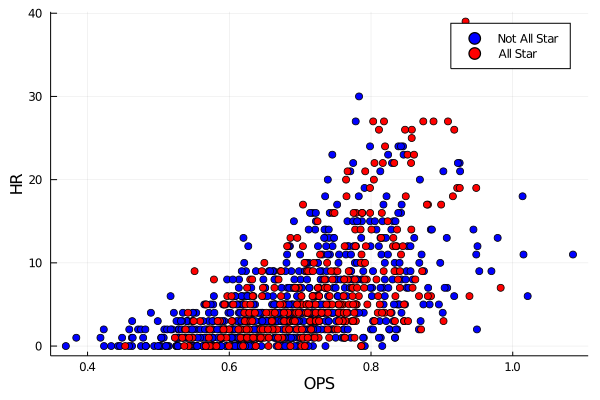

In [38]:
scatter(first_1970[:OPS][first_1970[:AS] .==0], first_1970[:HR][first_1970[:AS] .==0],color="blue",label="Not All Star")
scatter!(first_1970[:OPS][first_1970[:AS] .==1], first_1970[:HR][first_1970[:AS] .==1], color="red",label="All Star")
Plots.xlabel!("OPS")
Plots.ylabel!("HR")

In [39]:
y = first_1970[:AS]

1087-element Array{Any,1}:
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0

In [40]:
X = select(first_1970, Not([:AS, :playerID, :stint, :teamID,:team_ID,:lgID]));

In [41]:
for col in eachcol(X)
    replace!(col,NaN => 0)
end

In [42]:
[X[ismissing.(X[i]), i] = 0 for i in names(X)];

In [43]:
describe(X)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Union…,Type
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,yearID,1998.22,1970,2001.0,2018,,,Int64
3,G,76.0948,27,68.0,163,,,Int64
4,AB,239.186,100,198.0,692,,,Int64
5,R,30.7525,4,25.0,127,,,Int64
6,H,61.9917,15,50.0,242,,,Int64
7,2B,11.1582,0,9.0,47,,,Int64
8,3B,1.87029,0,1.0,15,,,Int64
9,HR,5.55842,0,4.0,39,,,Int64


In [44]:
using Random
function perclass_splits(y,at)
    uids = unique(y)
    keepids = []
    for ui in uids
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end

perclass_splits (generic function with 1 method)

In [45]:
trainids = perclass_splits(y,0.7)
testids = setdiff(1:length(y),trainids);

In [46]:
using StatsBase
using Statistics

In [47]:
std_ = []
for i in 1:ncol(X)
    temp = std(X[i])
    append!(std_, temp)
end

In [48]:
mean_ = []
for i in 1:ncol(X)
    temp = mean(X[i])
    append!(mean_, temp)
end

In [49]:
for col in 3:ncol(X)
    temp = (X[:,col] .- mean_[col]) ./std_[col]
    X[col] = temp
end

In [50]:
describe(X)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,yearID,1998.22,1970,2001.0,2018,,,Int64
3,G,7.1904e-17,-1.48159,-0.244285,2.62264,,,Float64
4,AB,-7.84408e-17,-1.08247,-0.320308,3.5216,,,Float64
5,R,-5.06597e-17,-1.33313,-0.286659,4.79618,,,Float64
6,H,-7.43553e-17,-1.25236,-0.319588,4.79735,,,Float64
7,2B,1.17661e-16,-1.47186,-0.284688,4.72782,,,Float64
8,3B,2.12444e-17,-0.903004,-0.420188,6.33924,,,Float64
9,HR,-2.61469e-17,-0.95666,-0.26822,5.75564,,,Float64


In [51]:
X[X[:SB].>= 12, :]

,ID,yearID,G,AB,R,H,2B,3B,HR,RBI
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,62427,1985,2.2605,3.08608,3.79954,2.8785,1.1663,3.92516,-0.78455,0.719582


In [52]:
first_1970[first_1970[:ID] .== 62427, :]

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,AB,R,H
,Int64,String,Int64,Int64,String,Int64,String,Int64,Int64,Int64,Int64
1,62427,colemvi01,1985,1,SLN,1941,NL,151,636,107,170


In [53]:
using DecisionTree

In [54]:
X = Matrix(X[:,:]);

In [55]:
assign_class(predictedvalue) = argmin(abs.(predictedvalue .- [1,2,3]))
findaccuracy(predictedvals,groundtruthvals) = sum(predictedvals.==groundtruthvals)/length(groundtruthvals)

findaccuracy (generic function with 1 method)

In [56]:
model = RandomForestClassifier(n_trees=50, min_samples_leaf=4, partial_sampling=0.5)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

RandomForestClassifier
n_trees:             50
n_subfeatures:       -1
partial_sampling:    0.5
max_depth:           -1
min_samples_leaf:    4
min_samples_split:   2
min_purity_increase: 0.0
classes:             Any[0, 1]
ensemble:            Ensemble of Decision Trees
Trees:      50
Avg Leaves: 49.46
Avg Depth:  13.78

In [57]:
q = X[testids,:];
predictions_RF = DecisionTree.predict(model, q)
findaccuracy(predictions_RF,y[testids])

0.7680722891566265

KNN

In [58]:
using NearestNeighbors
Xtrain = X[trainids,:]
ytrain = y[trainids]
kdtree = KDTree(Xtrain')

KDTree{StaticArrays.SArray{Tuple{24},Float64,1,24},Euclidean,Float64}
  Number of points: 755
  Dimensions: 24
  Metric: Euclidean(0.0)
  Reordered: true

In [59]:
queries = X[testids,:];
idxs, dists = knn(kdtree, queries', 5, true);

In [60]:
c = ytrain[hcat(idxs...)]
possible_labels = map(i->counter(c[:,i]),1:size(c,2))
predictions_NN = map(i->parse(Int,string(argmax(DataFrame(possible_labels[i])[1,:]))),1:size(c,2))
findaccuracy(predictions_NN,y[testids])

0.6867469879518072

SVM

In [61]:
Xtrain = X[trainids,:];
ytrain = y[trainids];

In [62]:
model = svmtrain(Xtrain', ytrain)

LIBSVM.SVM{Any}(SVC, LIBSVM.Kernel.RadialBasis, nothing, 24, 2, Any[0, 1], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Any,Float64}(755, Int32[529, 226], Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [48352.0 48404.0 … 105217.0 105712.0; 1970.0 1970.0 … 2018.0 2018.0; … ; -2.2582904460068183 -1.3175501432560672 … 1.1756793063647784 1.295823741795612; -2.319398883536755 -1.394488870487955 … 1.4990338237501029 1.1920843430662518], Int32[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  746, 747, 748, 749, 750, 751, 752, 753, 754, 755], LIBSVM.SVMNode[LIBSVM.SVMNode(1, 48352.0), LIBSVM.SVMNode(1, 48404.0), LIBSVM.SVMNode(1, 48465.0), LIBSVM.SVMNode(1, 48692.0), LIBSVM.SVMNode(1, 48710.0), LIBSVM.SVMNode(1, 48740.0), LIBSVM.SVMNode(1, 48964.0), LIBSVM.SVMNode(1, 49033.0), LIBSVM.SVMNode(1, 49154.0), LIBSVM.SVMNode(1, 49185.0)  …  LIBSVM.SVMNode(1, 101492.0), LIBSVM.SVMNode(1, 101619.0), LIBSVM.SVMNode(1, 101684.0), LIBSVM.SVMNode(1, 101906.0), LIBSVM.SVMNode(1, 102208.0), 

In [63]:
predictions_SVM, decision_values = svmpredict(model, X[testids,:]')
findaccuracy(predictions_SVM,y[testids])

0.7680722891566265

With Normalization

In [64]:
X = select(first_1970, Not([:AS, :playerID, :stint, :teamID,:team_ID,:lgID]));

In [65]:
using Random
function perclass_splits(y,at)
    uids = unique(y)
    keepids = []
    for ui in uids
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end

perclass_splits (generic function with 1 method)

In [66]:
trainids = perclass_splits(y,0.7)
testids = setdiff(1:length(y),trainids);

In [67]:
for col in 3:ncol(X)
    temp = (X[:,col] .- minimum(X[:,col])) ./(maximum(X[:,col]).-minimum(X[:,col]))
    X[col] = temp
end

In [68]:
describe(X)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,ID,79259.6,48221,81076.0,105844,,,Int64
2,yearID,1998.22,1970,2001.0,2018,,,Int64
3,G,0.360991,0.0,0.301471,1.0,,,Float64
4,AB,0.235111,0.0,0.165541,1.0,,,Float64
5,R,0.2175,0.0,0.170732,1.0,,,Float64
6,H,0.207012,0.0,0.154185,1.0,,,Float64
7,2B,0.237409,0.0,0.191489,1.0,,,Float64
8,3B,0.124686,0.0,0.0666667,1.0,,,Float64
9,HR,0.142524,0.0,0.102564,1.0,,,Float64


In [69]:
using DecisionTree
X = Matrix(X[:,:]);

In [70]:
model = RandomForestClassifier(n_trees=200, min_samples_leaf=4, partial_sampling=0.5)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

RandomForestClassifier
n_trees:             200
n_subfeatures:       -1
partial_sampling:    0.5
max_depth:           -1
min_samples_leaf:    4
min_samples_split:   2
min_purity_increase: 0.0
classes:             Any[0, 1]
ensemble:            Ensemble of Decision Trees
Trees:      200
Avg Leaves: 50.0
Avg Depth:  13.94

In [71]:
q = X[testids,:];
predictions_RF = DecisionTree.predict(model, q)
findaccuracy(predictions_RF,y[testids])

0.725752508361204

In [72]:
using NearestNeighbors
Xtrain = X[trainids,:]
ytrain = y[trainids]
kdtree = KDTree(Xtrain')

KDTree{StaticArrays.SArray{Tuple{24},Float64,1,24},Euclidean,Float64}
  Number of points: 788
  Dimensions: 24
  Metric: Euclidean(0.0)
  Reordered: true

In [73]:
queries = X[testids,:];
idxs, dists = knn(kdtree, queries', 5, true);
c = ytrain[hcat(idxs...)]
possible_labels = map(i->counter(c[:,i]),1:size(c,2))
predictions_NN = map(i->parse(Int,string(argmax(DataFrame(possible_labels[i])[1,:]))),1:size(c,2))
findaccuracy(predictions_NN,y[testids])

0.6655518394648829

In [74]:
Xtrain = X[trainids,:];
ytrain = y[trainids];
model = svmtrain(Xtrain', ytrain)
predictions_SVM, decision_values = svmpredict(model, X[testids,:]')
findaccuracy(predictions_SVM,y[testids])

0.7224080267558528